# Numerical solution of the mild slope equation in a two parabolic shoal 
## Bibliography
### Numerical solutions of mild slope equation by generalized ﬁnite diﬀerence method. Authors: Ting Zhang, Ying-Jie Huang, Lin Liang, Chia-Ming Fan, Po-Wei Li
### A Modified Mild‐Slope Model for the Hydrodynamic Analysis of Arrays of Heaving WECs in Variable Bathymetry Regions. Authors: Markos Bonovas, Alexandros Magkouris and Kostas Belibassakis 

# Libraries

In [43]:
import jax, optax, flax
import pickle
import functools
import matplotlib.pyplot, matplotlib.animation
import numpy

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_disable_jit', True) # Desactive the compilation for better debugging
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Neural network

In [44]:
class MLP(flax.linen.Module):
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure, activation function and a bool to indicates if it's occurring a training
     """
    layers: list
    training: bool

    @flax.linen.compact
    def __call__(self, x):
        """
        Compute the output of the neural network
        Parameters
        ----------
        x : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        x : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- numerical output of the neural network	(u,v,p)
        """
        
        x = flax.linen.BatchNorm(use_running_average=not self.training)(x)
        for i in range(1,len(self.layers)-1):
            x = flax.linen.Dense(self.layers[i])(x)
            x = flax.linen.BatchNorm(use_running_average=not self.training)(x)
            x = flax.linen.tanh(x)
            #x = nn.Dropout(rate=0.5, deterministic=not self.training)(x)
        x = flax.linen.Dense(self.layers[-1])(x)
        
        return x

# Operators

In [45]:
class PDE_operators:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    
    # Class initialization
    def __init__(self, psi_function, c_function, cg_function, solution):
        self.psi_function = psi_function
        self.c_function = c_function
        self.cg_function = cg_function
        self.solution = solution


    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_psi(self, params, inputs):
        """
        Compute the gradient of the psi function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        gradient : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient applied to the inputs
        """

        fun = lambda params, x, y: self.psi_function(params, x, y)

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(fun, 1)(params, x, y)
            u_y = jax.jacfwd(fun, 2)(params, x, y)
            return jax.numpy.column_stack((u_x, u_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

        return gradient

    @functools.partial(jax.jit, static_argnums=(0,))    
    def comp_grad_c_cg_gradpsi(self, params, inputs):
        """
        Compute the dot product nabla.(c*cg*gradpsi)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y)
        Returns
        -------
        res : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the dot_product nabla.(c*cg*gradpsi) applied to the inputs
        """

        funx = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)*self.comp_grad_psi(params, jax.numpy.column_stack((x, y)))[:,0]
        funy = lambda params, x, y: self.c_function(x,y)*self.cg_function(x,y)*self.comp_grad_psi(params, jax.numpy.column_stack((x, y)))[:,1]

        @functools.partial(jax.jit)    
        def action(params, x, y):               # function to vectorize the laplacian
            u_x = jax.jacfwd(funx, 1)(params, x, y)
            u_y = jax.jacfwd(funy, 2)(params, x, y)
            return u_x + u_y

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1])

        return res.reshape(-1)


    @functools.partial(jax.jit, static_argnums=(0,))    
    def dsol_dt(self, params, inputs):
        """
        Compute the time derivative os the solution
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,z,t)
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- numerical values of the time derivative applied to the inputs
        """

        fun = lambda params, x, y, z, t: self.solution(params, x, y, z, t)

        @functools.partial(jax.jit)    
        def action(params, x, y, z, t):               # function to vectorize the laplacian
            u_t = jax.jacfwd(fun, 4)(params, x, y, z, t)
            return u_t

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0, 0))
        res = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3])

        return res.reshape(-1)


# Physics Informed Neural Network

In [46]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """

    # Class initialization
    def __init__(self, NN_evaluation, optimizer):
        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer

        self.operators = PDE_operators(self.spatial_solution2d, self.c_coeff, self.cg_coeff, self.solution)
        self.gradient_psi = self.operators.comp_grad_psi
        self.dsol_dt = self.operators.dsol_dt
        self.gradient_c_cg_gradpsi = self.operators.comp_grad_c_cg_gradpsi
    


    #########################################################
    ################### Solution domain 2d ##################
    #########################################################
    def spatial_solution2d(self, params, inputX, inputY):
        """
        Compute the solution of the PDE on the points (x,y)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the mesh
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the mesh
        Returns
        -------
        applied_solution : jax.numpy.ndarray[batch_size]
            -- PINN solution applied to inputs. return u, a complex number
        """
        inputs = jax.numpy.column_stack((inputX, inputY))
        NN = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)
        NN_output = jax.lax.complex(NN[:,0],NN[:,1])   # The first output of the NN is the real part, the second is the imaginary part
        
        return NN_output


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_residual_pde(self, params, inputs):
        """
        Compute the residual of the pde inside the domain
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points from the mesh
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inputs
        """

        preds_loss = self.gradient_c_cg_gradpsi(params, inputs) + self.k_coeff(inputs[:,0],inputs[:,1])**2*self.c_coeff(inputs[:,0], inputs[:,1])*self.cg_coeff(inputs[:,0], inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])
        loss_value = jax.numpy.linalg.norm(preds_loss)**2/preds_loss.shape[0]
        return loss_value


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_reflective_left_boundary(self, params, inputs):
        """
        Compute the loss function at the left boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_left : a float.64
            -- loss function applied to inputs
        """
        normal_left = jax.numpy.column_stack((-jax.numpy.ones(inputs.shape[0]), jax.numpy.zeros(inputs.shape[0])))
        preds_left = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_left)
        loss_left = jax.numpy.linalg.norm(preds_left)**2/preds_left.shape[0]
        
        return loss_left


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_reflective_right_boundary(self, params, inputs):
        """
        Compute the loss function at the right boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_right : a float.64
            -- loss function applied to inputs
        """
        normal_right = jax.numpy.column_stack((jax.numpy.ones(inputs.shape[0]), jax.numpy.zeros(inputs.shape[0])))
        preds_right = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_right)
        loss_right = jax.numpy.linalg.norm(preds_right)**2/preds_right.shape[0]
        
        return loss_right


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_absorbing_boundary(self, params, inputs):
        """
        Compute the loss function at the behind boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_behind : a float.64
            -- loss function applied to inputs
        """
        normal_behind = jax.numpy.column_stack((jax.numpy.zeros(inputs.shape[0]),jax.numpy.ones(inputs.shape[0])))
        preds_behind = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_behind) - jax.lax.complex(-jax.numpy.imag(self.k_coeff(inputs[:,0], inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])), jax.numpy.real(self.k_coeff(inputs[:,0], inputs[:,1])*self.spatial_solution2d(params, inputs[:,0], inputs[:,1])))
        loss_behind = jax.numpy.linalg.norm(preds_behind)**2/preds_behind.shape[0]
      
        return loss_behind


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_incident_boundary(self, params, inputs):
        """
        Compute the loss function at the front boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_front : a float.64
            -- loss function applied to inputs
        """
        normal_front = jax.numpy.column_stack((jax.numpy.zeros(inputs.shape[0]),jax.numpy.ones(inputs.shape[0])))
        preds_front = jax.numpy.einsum('ij,ij->i',self.gradient_psi(params, inputs), normal_front) - jax.lax.complex(-jax.numpy.imag(self.k_coeff(inputs[:,0], inputs[:,1])*(2*self.incident_psi(params, inputs)-self.spatial_solution2d(params, inputs[:,0], inputs[:,1]))), jax.numpy.real(self.k_coeff(inputs[:,0], inputs[:,1])*(2*self.incident_psi(params, inputs)-self.spatial_solution2d(params, inputs[:,0], inputs[:,1]))))
        loss_front = jax.numpy.linalg.norm(preds_front)**2/preds_front.shape[0]
      
        return loss_front


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_function(self, params, inside, up_points, down_points, left_points, right_points):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss_sum : a float.64
            -- loss function applied to inputs
        losses : numpy.array(loss_residual, loss_bound, loss_front_behind)
            -- current values of each loss function
        """

        loss1 = self.loss_incident_boundary(params, down_points) 
        loss2 = self.loss_absorbing_boundary(params, up_points)
        loss3 = self.loss_reflective_left_boundary(params, left_points)
        loss4 = self.loss_reflective_right_boundary(params, right_points)

        loss_bound = loss3 + loss4
        loss_residual = self.loss_residual_pde(params, inside)
        loss_front_behind = loss1 + loss2
        loss_sum = loss_bound + loss_residual + loss_front_behind
        losses = jax.numpy.array([loss_residual, loss_bound, loss_front_behind])

        return loss_sum, losses


    @functools.partial(jax.jit, static_argnums=(0,))    
    def train_step(self, params, opt_state, inside, up_points, down_points, left_points, right_points):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside, up_points, down_points, left_points, right_points)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses




    #########################################################
    #################### Physical domain ####################
    #########################################################
    @functools.partial(jax.jit, static_argnums=(0,))    
    def omega_coeff(self, x, y):
        """
        Compute the frequency omega at in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        omega : jax.numpy.ndarray[batch_size]
            -- omega in each couple (x,y)
        """
        omega = jax.numpy.sqrt(9.81*self.k_coeff(x,y)*jax.numpy.tanh(self.k_coeff(x,y)*self.height_function(x,y)))
        
        return omega


    @functools.partial(jax.jit, static_argnums=(0,))    
    def k_coeff(self, x, y):
        """
        Compute the coefficient k in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        k : jax.numpy.ndarray[batch_size]
            -- Coefficient k in each couple (x,y)
        """

        return 0.5


    @functools.partial(jax.jit, static_argnums=(0,))    
    def c_coeff(self, x, y):
        """
        Compute the coefficient c in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        c : jax.numpy.ndarray[batch_size]
            -- Coefficient c in each couple (x,y)
        """
        c = self.omega_coeff(x,y)/self.k_coeff(x,y)

        return c


    @functools.partial(jax.jit, static_argnums=(0,))    
    def cg_coeff(self, x, y):
        """
        Compute the coefficient cg in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        cg : jax.numpy.ndarray[batch_size]
            -- Coefficient cg in each couple (x,y)
        """
        nprime = 0.5*(1 + 2*self.k_coeff(x,y)*self.height_function(x,y)/jax.numpy.sinh(2*self.k_coeff(x,y)*self.height_function(x,y)))
        cg = nprime*self.omega_coeff(x,y)/self.k_coeff(x,y)

        return cg


    @functools.partial(jax.jit, static_argnums=(0,))    
    def height_function(self, x, y):
        """
        Compute the height in the couple (x,y)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        Returns
        -------
        h : jax.numpy.ndarray[batch_size]
            -- Height each couple (x,y)
        """
        fun = lambda tx, ty: XYZ_down[:,2][jax.numpy.argmin(jax.numpy.sqrt(((tx-XYZ_down[:,0])**2+(ty-XYZ_down[:,1])**2)))]
        vec_fun = jax.vmap(jax.jit(fun), in_axes = (0, 0))
        h = -vec_fun(x.reshape(-1), y.reshape(-1))

        return h


    @functools.partial(jax.jit, static_argnums=(0,))    
    def f_dependence(self, inputX, inputY, inputZ):
        """
        Compute the function fz in the point (x,y,z)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        Returns
        -------
        fz : jax.numpy.ndarray[batch_size]
            -- fz in each point (x,y,z)
        """
        fz = (jax.numpy.cosh(self.k_coeff(inputX, inputY)*(self.height_function(inputX, inputY)+ inputZ))/jax.numpy.cosh(self.k_coeff(inputX, inputY)*self.height_function(inputX, inputY))).reshape(-1)

        return fz


    @functools.partial(jax.jit, static_argnums=(0,))    
    def solution(self, params, x,y,z,t):
        """
        Compute the solution in the point (x,y,z,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        z : jax.numpy.ndarray[batch_size]
            -- points in the axis z
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- result in each point (x,y,z,t)
        """
        H = 2*self.omega_coeff(x,y)*abs(self.spatial_solution2d(params,x,y))/9.81
        #res = jax.numpy.real(9.81*H/(2*self.omega_coeff(x,y))*self.spatial_solution2d(params, x,y)*self.f_dependence(x,y,z)*jax.numpy.exp(jax.lax.complex(0.0,-self.omega_coeff(x,y)*t)))
        res = jax.numpy.imag(9.81*H/(2*self.omega_coeff(x,y))*self.spatial_solution2d(params, x,y)*self.f_dependence(x,y,z)*jax.numpy.exp(jax.lax.complex(0.0,jax.numpy.real(-self.omega_coeff(x,y)*t))))

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def elevation(self, params, x,y,t):
        """
        Compute the surface displacement in the point (x,y,t)
        Parameters
        ----------
        x : jax.numpy.ndarray[batch_size]
            -- points in the axis x
        y : jax.numpy.ndarray[batch_size]
            -- points in the axis y
        t : jax.numpy.ndarray[batch_size]
            -- points in the time
        Returns
        -------
        res : jax.numpy.ndarray[batch_size]
            -- Displacement in each point (x,y,z,t)
        """
        inputs = jax.numpy.column_stack((x,y,jax.numpy.zeros_like(y),t))
        res = -self.dsol_dt(params, inputs)/9.81

        return res


    @functools.partial(jax.jit, static_argnums=(0,))    
    def incident_psi(self, params, inputs, a=0.01):
        """
        Compute the incident wave in inputs points
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size]]
            -- (x,y) points in the mesh
        Returns
        -------
        incident_wave : a float.64
            -- incident_wave applied to inputs
        """
        incident_wave = (2*a*9.81/self.c_coeff(inputs[:,0], inputs[:,1])*jax.numpy.exp(-self.k_coeff(inputs[:,0],inputs[:,1])*inputs[:,1])).reshape(-1)
        
        return incident_wave


# Parameters

In [47]:
# Neural network parameters
SEED = 351
n_features, n_targets = 2, 2            # Input and output dimension (input is the couple (x,y), output is a complex number)
layers = [n_features, 50, n_targets]             # Layers structure

# Training parameters
#lr_scheduler = optax.linear_schedule(0.005, 0.00001, transition_steps = 50, transition_begin = 1000)  # learning rate
lr_scheduler = 0.005     
optimizer = optax.adam(lr_scheduler)
maximum_num_epochs = 10000
report_steps = 100
options = 1 # If 1 we start a new training

# Data parameters
N_inside = 2500        # number of points inside the mesh
N_bound = 200           # number of points at the boundary
domain_bounds = jax.numpy.column_stack(([-jax.numpy.pi, -jax.numpy.pi, 0], [jax.numpy.pi, jax.numpy.pi, -jax.numpy.pi]))        # minimal and maximal value of each axis (x,y,t)
radius = 1


# 3D dataset creation

In [48]:
#### Boundary data
### Down 
X, Y, Z = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4), jax.numpy.linspace(domain_bounds[2,0],domain_bounds[2,0],1)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
down = jax.numpy.column_stack((X,Y,Z))
down = down[(down[:,0]-1.5)**2+down[:,1]**2+down[:,2]**2>radius**2]
down = down[(down[:,0]+1.5)**2+down[:,1]**2+down[:,2]**2>radius**2]

ran_key, batch_key = jax.random.split(jax.random.PRNGKey(0))
down_circle_bound = numpy.random.uniform(size=(10000000, 3), low=jax.numpy.array([-radius,-radius,-radius]), high=jax.numpy.array([radius, radius, radius]))
down_circle_bound = down_circle_bound[down_circle_bound[:,0]**2 + down_circle_bound[:,1]**2 + down_circle_bound[:,2]**2 < radius**2 + 0.001]
down_circle_bound = down_circle_bound[down_circle_bound[:,0]**2 + down_circle_bound[:,1]**2 + down_circle_bound[:,2]**2 > radius**2 - 0.001]
down_circle_bound1 = numpy.copy(down_circle_bound)
down_circle_bound2 = numpy.copy(down_circle_bound)
down_circle_bound1[:,0] = down_circle_bound1[:,0]+1.5
down_circle_bound2[:,0] = down_circle_bound2[:,0]-1.5
XYZ_down = jax.numpy.concatenate((down, down_circle_bound1, down_circle_bound2))

XYZ_down = numpy.column_stack((XYZ_down[:,0], XYZ_down[:,1], XYZ_down[:,2] + domain_bounds[2,1]))
XYZ_down = XYZ_down[XYZ_down[:,2]>=domain_bounds[2,1]]

### Rotate xy 90 degrees
aux = numpy.copy(XYZ_down[:,1])
XYZ_down[:,1] = XYZ_down[:,0]
XYZ_down[:,0] = aux
XYZ_down = jax.numpy.array(XYZ_down)


### Up
X, Y, Z = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4), jax.numpy.linspace(domain_bounds[2,1],domain_bounds[2,1],1)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_up = jax.numpy.column_stack((X,Y, Z- domain_bounds[2,1]))


### Left
X, Y, Z = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,0],1), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4), jax.numpy.linspace(domain_bounds[2,0],domain_bounds[2,1],N_bound//4)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_left = jax.numpy.column_stack((X, Y, Z ))


### Right
X, Y, Z = jax.numpy.linspace(domain_bounds[0,1],domain_bounds[0,1],1), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4), jax.numpy.linspace(domain_bounds[2,0],domain_bounds[2,1],N_bound//4)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_right = jax.numpy.column_stack((X, Y, Z))


### Front
X, y, Z = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,0],1), jax.numpy.linspace(domain_bounds[2,0],domain_bounds[2,1],N_bound//4)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_flow = jax.numpy.column_stack((X, Y, Z))


### Behind
X, Y, Z = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4), jax.numpy.linspace(domain_bounds[1,1],domain_bounds[1,1],1), jax.numpy.linspace(domain_bounds[2,0],domain_bounds[2,1],N_bound//4)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_behind = jax.numpy.column_stack((X, Y, Z))

XYZ_bound = jax.numpy.concatenate((XYZ_left, XYZ_right))


### Flow
X, Y, Z = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],6), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,0],1), jax.numpy.linspace(domain_bounds[2,0],domain_bounds[2,1],6)
X, Y, Z = jax.numpy.meshgrid(X, Y, Z)
X, Y, Z = X.flatten(), Y.flatten(), Z.flatten()
XYZ_flow = jax.numpy.column_stack((X, Y, Z))

# 3D dataset plot

Number of points on the ground: 17784
Number of points: 25284


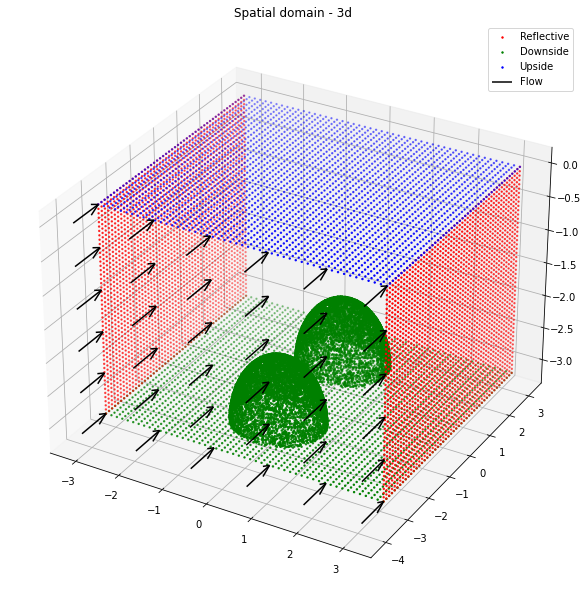

In [49]:
fig = matplotlib.pyplot.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(projection='3d')
title = ax.set_title('Spatial domain - 3d')
graph = ax.scatter(XYZ_bound[:,0],XYZ_bound[:,1],XYZ_bound[:,2],color='red',s=2)
#graph = ax.scatter(XYZ_front[:,0],XYZ_front[:,1],XYZ_front[:,2],color='yellow',s=1)
#graph = ax.scatter(XYZ_behind[:,0],XYZ_behind[:,1],XYZ_behind[:,2],color='black',s=1)
graph = ax.scatter(XYZ_down[:,0], XYZ_down[:,1], XYZ_down[:,2], color='green', s=2)
graph = ax.scatter(XYZ_up[:,0],XYZ_up[:,1],XYZ_up[:,2],color='blue',s=2)
ax.quiver(XYZ_flow[:,0],XYZ_flow[:,1]-1,XYZ_flow[:,2],0,1,0,length=1,color='black',normalize=True)
#__ = ax.legend(['Reflective','In','Out','Downside','Upside'])

__ = ax.legend(['Reflective','Downside','Upside','Flow'])
print('Number of points on the ground:', XYZ_down.shape[0])
print('Number of points:', XYZ_bound.shape[0]+XYZ_up.shape[0]+XYZ_down.shape[0])
fig.savefig('./images/domain3d.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# 2D dataset creation

In [50]:
#### Boundary data
### Down
x, y = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,0],1)
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_front = jax.numpy.column_stack((x, y))


### Up
x, y = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,1],N_bound//4), jax.numpy.linspace(domain_bounds[1,1],domain_bounds[1,1],1)
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
xy_behind = jax.numpy.column_stack((x, y))


### Left
x, y = jax.numpy.linspace(domain_bounds[0,0],domain_bounds[0,0],1), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4)
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_left = jax.numpy.column_stack((x, y))


### Right
x, y = jax.numpy.linspace(domain_bounds[0,1],domain_bounds[0,1],1), jax.numpy.linspace(domain_bounds[1,0],domain_bounds[1,1],N_bound//4)
x, y = jax.numpy.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
xy_right = jax.numpy.column_stack((x, y))

xy_bound = jax.numpy.concatenate((xy_left, xy_right))


### Inside 
x = jax.numpy.linspace(domain_bounds[0,0]+5/int(jax.numpy.sqrt(N_inside)),domain_bounds[0,1]-5/int(jax.numpy.sqrt(N_inside)), int(jax.numpy.sqrt(N_inside)))
y = jax.numpy.linspace(domain_bounds[1,0]+5/int(jax.numpy.sqrt(N_inside)),domain_bounds[1,1]-5/int(jax.numpy.sqrt(N_inside)),int(jax.numpy.sqrt(N_inside)))
x, y = jax.numpy.meshgrid(x,y)
x, y = x.flatten(), y.flatten()
xy_inside = jax.numpy.column_stack((x, y))


# 2D dataset plot

Number of points on the boundary: 200
Number of points inside the domain: 2500


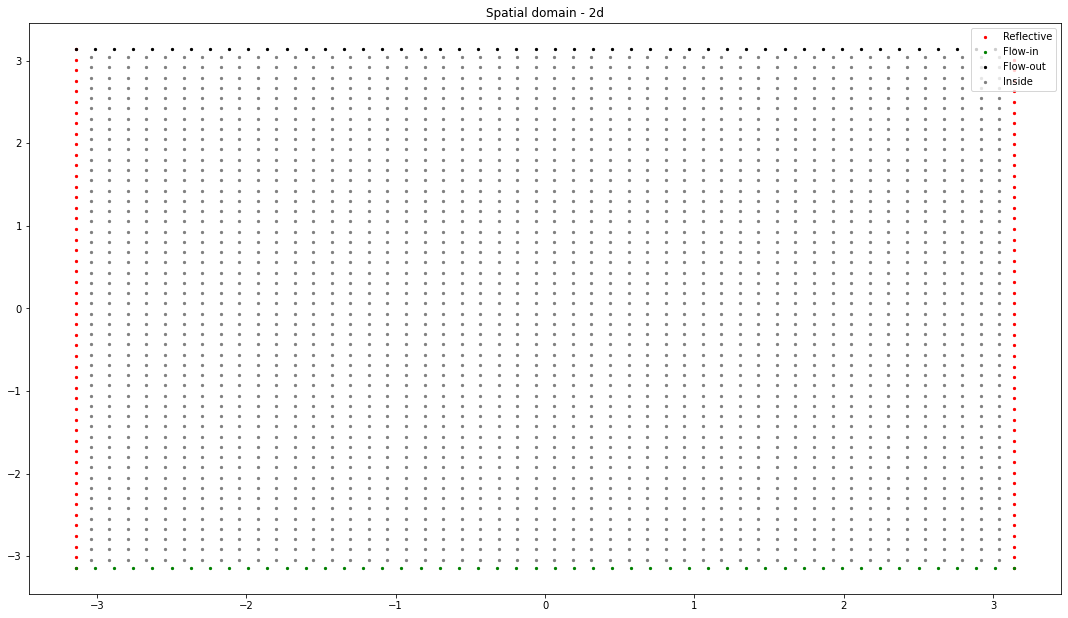

In [51]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18.5, 10.5)
title = ax.set_title('Spatial domain - 2d')
graph = matplotlib.pyplot.scatter(xy_bound[:,0],xy_bound[:,1],color='red',s=5)
graph = matplotlib.pyplot.scatter(xy_front[:,0],xy_front[:,1],color='green',s=5)
graph = matplotlib.pyplot.scatter(xy_behind[:,0],xy_behind[:,1],color='black',s=5)
graph = matplotlib.pyplot.scatter(xy_inside[:,0],xy_inside[:,1], color='gray', s=5)
__ = ax.legend(['Reflective','Flow-in','Flow-out','Inside'])
print('Number of points on the boundary:', xy_bound.shape[0]+xy_front.shape[0]+xy_behind.shape[0])
print('Number of points inside the domain:', xy_inside.shape[0])

matplotlib.pyplot.savefig('./images/domain2d.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# Model initialization

In [52]:
training_model = MLP(layers, training=True)     
key1, key2, key3 = jax.random.split(jax.random.PRNGKey(SEED), 3)
x = jax.random.uniform(key1, (10, layers[0]))
params = training_model.init({'params': key2}, x)

eval_model = MLP(layers, training=False)
NN_eval = eval_model.apply   # Evaluate function

solver = PINN(NN_eval, optimizer)

opt_state = optimizer.init(params)

# Training

In [53]:
loss_history = []
print("Training start")
if options == 1:            # begin a new training
    loss_history = []
    loss_r = []               # residual loss
    loss_b = []               # boundary loss
    loss_i = []               # boundary initial condition

    # Main loop to solve the PDE
    for ibatch in range(maximum_num_epochs+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, xy_inside, xy_behind, xy_front, xy_left, xy_right)

        loss_r.append(float(losses[0]))
        loss_b.append(float(losses[1]))
        loss_i.append(float(losses[2]))

        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%report_steps==report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./NN_saves/params_checkpoint_mild", "wb"))
            pickle.dump(opt_state, open("./NN_saves/opt_state_checkpoint_mild", "wb"))
            pickle.dump(loss_history, open("./NN_saves/loss_history_mild", "wb"))
            pickle.dump(loss_r, open("./NN_saves/loss_r_mild", "wb"))
            pickle.dump(loss_b, open("./NN_saves/loss_b_mild", "wb"))
            pickle.dump(loss_i, open("./NN_saves/loss_i_mild", "wb"))

elif options == 2:      # continue the last training
    params = pickle.load(open("./NN_saves/params_checkpoint_mild", "rb"))
    opt_state = pickle.load(open("./NN_saves/opt_state_checkpoint_mild", "rb"))
    loss_history = pickle.load(open("./NN_saves/loss_history_mild", "rb"))
    loss_r = pickle.load(open("./NN_saves/loss_r_mild", "rb"))
    loss_b = pickle.load(open("./NN_saves/loss_b_mild", "rb"))
    loss_i = pickle.load(open("./NN_saves/loss_i_mild", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch,maximum_num_epochs+1):
        loss, params, opt_state, losses = solver.train_step(params, opt_state, xy_inside, xy_behind, xy_front, xy_left, xy_right)

        loss_r.append(float(losses[0]))
        loss_b.append(float(losses[1]))
        loss_i.append(float(losses[2]))

        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%report_steps==report_steps-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./NN_saves/params_checkpoint_mild", "wb"))
            pickle.dump(opt_state, open("./NN_saves/opt_state_checkpoint_mild", "wb"))
            pickle.dump(loss_history, open("./NN_saves/loss_history_mild", "wb"))
            pickle.dump(loss_r, open("./NN_saves/loss_r_mild", "wb"))
            pickle.dump(loss_b, open("./NN_saves/loss_b_mild", "wb"))
            pickle.dump(loss_i, open("./NN_saves/loss_i_mild", "wb"))

Training start
Epoch n°100:  0.07122136952341103
Epoch n°200:  0.02432585685388778
Epoch n°300:  0.014100873855088153
Epoch n°400:  0.009784916964837348
Epoch n°500:  0.007105224276133767
Epoch n°600:  0.0053035140081498
Epoch n°700:  0.00404226432949753
Epoch n°800:  0.0031404000403883513
Epoch n°900:  0.0024837208660000295
Epoch n°1000:  0.0019962471191394444
Epoch n°1100:  0.001627972323659332
Epoch n°1200:  0.001345647702823829
Epoch n°1300:  0.0011264524494539465
Epoch n°1400:  0.0009542777173591998
Epoch n°1500:  0.00081759271544329
Epoch n°1600:  0.0007080226458628445
Epoch n°1700:  0.0006193738805875956
Epoch n°1800:  0.0005469647071266463
Epoch n°1900:  0.0004873211351442621
Epoch n°2000:  0.0004376028363032435
Epoch n°2100:  0.0003956040547256896
Epoch n°2200:  0.00035954527233450826
Epoch n°2300:  0.0003282515830814778
Epoch n°2400:  0.0003007242939627885
Epoch n°2500:  0.0002761417654037327
Epoch n°2600:  0.0002606326598726155
Epoch n°2700:  0.0002343914158640153
Epoch n°28

# Loss function

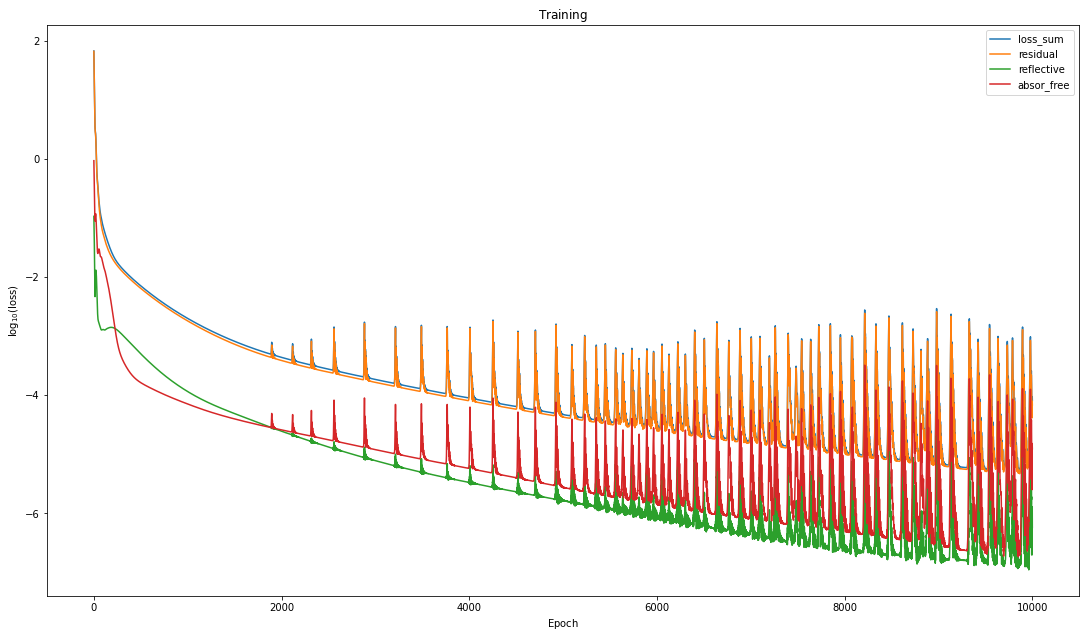

In [54]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
fig.set_size_inches(18.5, 10.5)
__ = ax.plot(numpy.log10(loss_history))
__ = ax.plot(numpy.log10(numpy.array(loss_r)))
__ = ax.plot(numpy.log10(numpy.array(loss_b)))
__ = ax.plot(numpy.log10(numpy.array(loss_i)))
xlabel = ax.set_xlabel(r'${\rm Epoch}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss_sum','residual','reflective','absor_free'])
matplotlib.pyplot.savefig('./images/loss_function.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()

# Elevation in t = 0

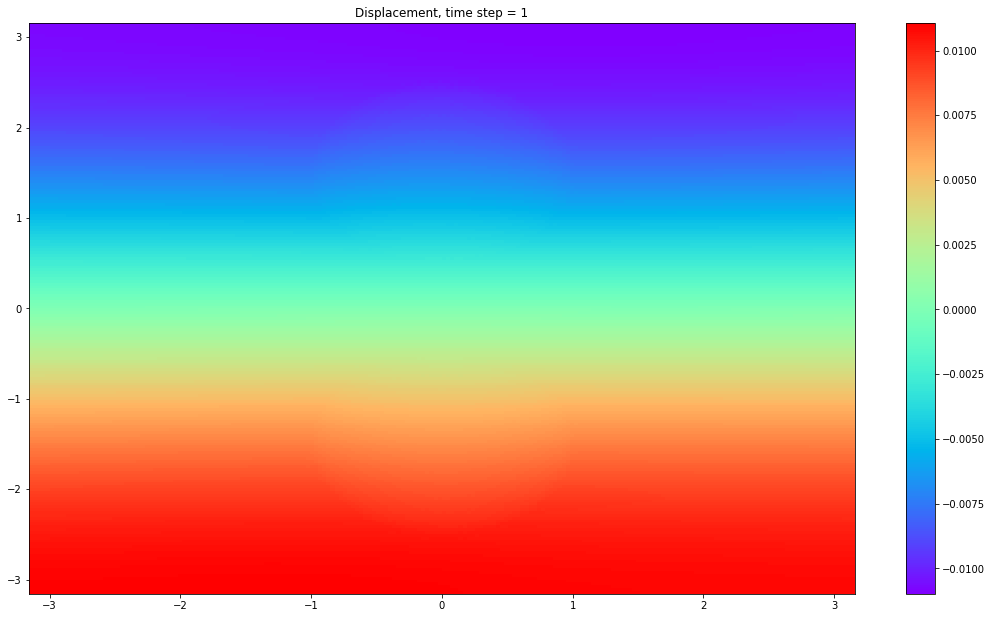

In [55]:
npoints = 200
values = numpy.zeros((npoints,npoints))

x, y = numpy.meshgrid(numpy.linspace(domain_bounds[0,0], domain_bounds[0,1], npoints), numpy.linspace(domain_bounds[1,0], domain_bounds[1,1], npoints))
t = jax.numpy.zeros(x.shape[0])

fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18.5, 10.5)
title = ax.set_title('Displacement, time step = 1')

for i in range(npoints):
    print("Plotting: {} out of {}".format(i+1, npoints), end='\r')
    values[i,:] = solver.elevation(params, x[i,:], y[i,:], t)

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'rainbow')
matplotlib.pyplot.colorbar()
matplotlib.pyplot.savefig('./images/mild_slope.png', facecolor='white', bbox_inches = 'tight')
matplotlib.pyplot.show()  

# 2D animation

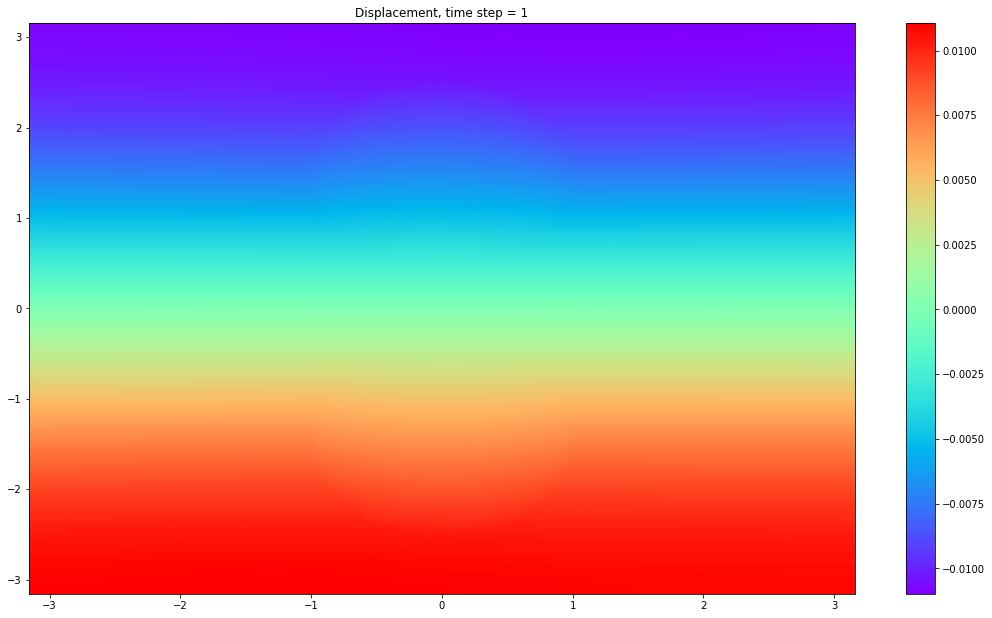

In [56]:
npoints = 200
frames = 200
end_time = 5.0
values = numpy.zeros((npoints,npoints))

x, y = numpy.meshgrid(numpy.linspace(domain_bounds[0,0], domain_bounds[0,1], npoints), numpy.linspace(domain_bounds[1,0], domain_bounds[1,1], npoints))
t = numpy.repeat(numpy.linspace(0, end_time, frames), npoints).reshape(frames, npoints)

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[num,:])
    title.set_text('Displacement, time step = {}'.format(num+1))
    graph.set_array(values.flatten())
    return fig,

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18.5, 10.5)
title = ax.set_title('Displacement, time step = 1')

for i in range(npoints):
    values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[0,:])

#graph = ax.scatter(x.flatten(), y.flatten(), c=values.flatten(), cmap = 'rainbow', s=10)
graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'rainbow')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames,  blit = False)
matplotlib.pyplot.colorbar(graph, ax=ax)
matplotlib.pyplot.show()  
ani.save('./images/mild_slope_animation.gif', writer='pillow', fps = 10)

# 3D animation

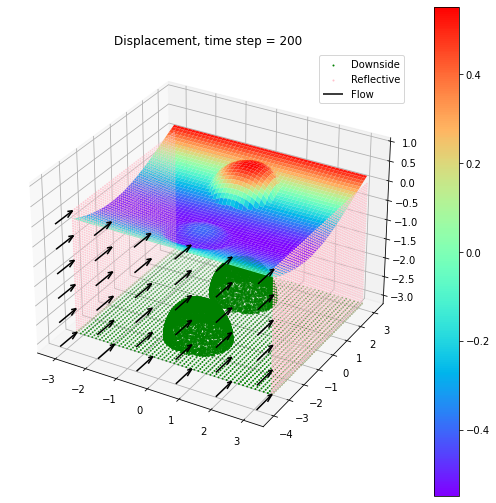

In [57]:
npoints = 200
frames = 200
end_time = 5.0
values = numpy.zeros((npoints,npoints))
scale = 50

x, y = numpy.meshgrid(numpy.linspace(domain_bounds[0,0], domain_bounds[0,1], npoints), numpy.linspace(domain_bounds[1,0], domain_bounds[1,1], npoints))
t = numpy.repeat(numpy.linspace(0, end_time, frames), npoints).reshape(frames, npoints)

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    ax.cla()

    graph = ax.scatter(XYZ_down[:,0], XYZ_down[:,1], XYZ_down[:,2], color='green', s=1)
    graph = ax.scatter(XYZ_bound[:,0],XYZ_bound[:,1],XYZ_bound[:,2],color='pink',s=1)
    ax.quiver(XYZ_flow[:,0],XYZ_flow[:,1]-1,XYZ_flow[:,2],0,1,0,length=1,color='black',normalize=True)
    for i in range(npoints):
        values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[num,:])
    ax.plot_surface(x,y,scale*values,cmap='rainbow')

    __ = ax.legend(['Downside','Reflective','Flow'])
    ax.set_zlim(domain_bounds[2,1], domain_bounds[2:,0]+1)
    ax.set_title('Displacement, time step = {}'.format(num+1))

    return fig,


fig = matplotlib.pyplot.figure(facecolor='white')
fig.set_size_inches(9, 9)
ax = fig.add_subplot(111,projection='3d')

for i in range(npoints):
    values[i,:] = solver.elevation(params, x[i,:], y[i,:], t[0,:])
graph = ax.plot_surface(x, y, scale*values, cmap = 'rainbow')
matplotlib.pyplot.colorbar(graph, ax=ax)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames,  blit = False)
ani.save('./images/mild_slope_animation3d.gif', writer='pillow', fps = 10)
